In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
def load_data(path):
    # Load intents
    with open(path, 'r') as file:
        intents = json.load(file)['intents']

    intents_dict = {}
    response_dict = {}
    for intent in intents:
        intents_dict[intent['tag']] = intent['patterns']
        response_dict[intent['tag']] = intent['responses']

    return intents_dict, response_dict

In [3]:
intents_dict, response_dict = load_data('../clean_data/intents_enriched.json')
n_categories = len(intents_dict)
print(n_categories)

13


In [4]:
def process_intents(intents_dict):
    lemmatizer = WordNetLemmatizer()

    words = []
    intents = []
    words_tokenized = []
    ignore = ['?', '!', '.', ',']

    for intent in intents_dict:
        for pattern in intents_dict[intent]:
            w = nltk.tokenize.word_tokenize(pattern)
            words.extend(w) # append words from tokenized pattern to 'words'
            words_tokenized.append((w, intent)) # list of tuples containing list of words and intent class
            if intent not in intents:
                intents.append(intent) # unique list of intents

    # find base form of word and remove ignore words
    words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore]
    words = sorted(list(set(words))) # remove duplicates and sort

    intents = sorted(intents)

    return words, intents, words_tokenized

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
# full list of unique words, intents, and tokenized words, paired with their
# associated intent class
words, intents, words_tokenized = process_intents(intents_dict)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rgbmr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rgbmr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Bag of words approach
<a id='bagofwords'></a>

In [6]:
def bag_of_words(words_tokenized, words, intents):
    lemmatizer = WordNetLemmatizer()
    features = []
    labels = []

    for pair in words_tokenized:
        words_encoded = []
        pattern_words = pair[0] # list of words
        # these words still need lemmatized
        pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
        for w in words:
            # binary representation of whether each word is present in the pattern
            words_encoded.append(1 if w in pattern_words else 0)

        # make list of 0s with size = # of intents
        intents_encoded = [0] * len(intents)
        # set index of intent from sorted, unique list of intents to 1 in intents_encoded
        intents_encoded[intents.index(pair[1])] = 1 # pair[1] is the intent

        features.append(words_encoded)
        labels.append(intents_encoded)

    # ensures compatibility with numpy-based ML frameworks and enables batch processing
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [7]:
# features, labels = bag_of_words(chosen_data, words, choices)
features, labels = bag_of_words(words_tokenized, words, intents)

Baseline model
<a id='baseline'></a>

In [8]:
class RNN(nn.Module):
    name = "RNN" # for keeping track of model type
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
        # Check that input size matches expected size
        if input.size(1) != self.i2o.in_features - self.hidden_size:
            raise ValueError("Input size mismatch: expected {}, got {}".format(
                self.i2o.in_features - self.hidden_size, input.size(1)
            ))
        combined = torch.cat((input, hidden), 1)
        # Ensure combined size matches linear layer input
        if combined.size(1) != self.i2o.in_features:
            raise RuntimeError("Concatenated size mismatch: expected {}, got {}".format(
                self.i2o.in_features, combined.size(1)
            ))
        hidden = self.i2o(combined)
        hidden = self.ReLU(hidden)
        hidden = self.dropout(hidden)
        output = self.softmax(hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size).to(device)

In [9]:
learning_rate = 0.001

def train(model, category_tensor, line_tensor, criterion, optimizer):
    category_indices = category_tensor.argmax(dim=1)  # Convert to integer indices
    model.zero_grad()
    hidden = model.initHidden(line_tensor.size(0))
    output, _ = model(line_tensor.to(device), hidden)
    loss = criterion(output, category_indices)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    loss.backward()
    optimizer.step()
    return output, loss.item()

K-Folds Cross-Validation
<a id='kfolds'></a>

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.optim as optim
import torch.utils.data as data

def train_and_validate(features, labels, n_hidden, learning_rate, batch_size, n_iters, model_type, n_splits):
    # Initialize KFold with n_splits
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    # Store results
    fold_accuracies = []
    fold_losses = []
    fold_f1 = []
    fold_precisions = []
    fold_recalls = []
    fold_val_accuracies = []  # For tracking validation accuracies
    fold_train_accuracies = []  # For tracking training accuracies

    input_size = len(features[0])
    output_size = len(labels[0])  # Number of intents

    for train_idx, test_idx in kf.split(features):
        # Create training and test datasets
        x_train = features[train_idx]
        y_train = labels[train_idx]
        x_test = features[test_idx]
        y_test = labels[test_idx]

        # Create DataLoaders for batching
        train_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test)), batch_size=batch_size, shuffle=False, drop_last=True)

        # Initialize a new model for each fold
        model = model_type(input_size, n_hidden, output_size)

        # Move the model to the correct device
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Reset loss tracking for each fold
        epoch_losses = []
        train_accuracies = []  # Reset train accuracies
        test_accuracies = []  # Reset test accuracies

        # Training loop for the current fold
        for epoch in range(n_iters):
            running_loss = 0.0
            correct = 0
            total = 0
            for line_tensor, category_tensor in train_loader:
                line_tensor = line_tensor.to(device)
                category_tensor = category_tensor.to(device)

                model.zero_grad()  # Reset gradients

                hidden = model.initHidden(line_tensor.size(0))
                output, hidden = model(line_tensor, hidden)

                loss = criterion(output, category_tensor.argmax(dim=1))  # Assuming one-hot encoded labels
                running_loss += loss.item()  # Track total loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update weights

                _, predicted = output.max(1)  # Get predictions
                total += category_tensor.size(0)  # Total samples
                correct += (predicted == category_tensor.argmax(dim=1)).sum().item()  # Correct predictions

            # Calculate average loss and accuracy for this epoch
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct / total

            # Store loss and training accuracy
            epoch_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)

            # Evaluate on the test set
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct_val = 0
                total_val = 0
                for line_tensor, category_tensor in test_loader:
                    line_tensor = line_tensor.to(device)
                    category_tensor = category_tensor.to(device)
                    hidden = model.initHidden(line_tensor.size(0)) # Initialize hidden state
                    output, hidden = model(line_tensor, hidden) # get output
                    _, preds = output.max(1)  # Get predictions
                    total_val += category_tensor.size(0)  # Total samples
                    correct_val += (preds == category_tensor.argmax(dim=1)).sum().item()  # Correct predictions

            # Calculate validation accuracy while training to monitor overfitting
            val_accuracy = correct_val / total_val
            test_accuracies.append(val_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch {epoch + 1}/{n_iters}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%")

        # Store results for this fold
        fold_losses.append(epoch_losses)
        fold_train_accuracies.append(train_accuracies)
        fold_val_accuracies.append(test_accuracies)

        # Calculate final accuracy for the current fold
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for line_tensor, category_tensor in test_loader:
                line_tensor = line_tensor.to(device)
                category_tensor = category_tensor.to(device)

                hidden = model.initHidden(line_tensor.size(0))
                output, hidden = model(line_tensor, hidden)

                _, preds = output.max(1)  # Get predictions
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(category_tensor.cpu().numpy())

        # Calculate test accuracy, precision, recall, and F1 score
        accuracy = accuracy_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds])
        precision = precision_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds], average="weighted")
        recall = recall_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds], average="weighted")
        f1 = f1_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds], average="weighted")

        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1.append(f1)

        print(f"Final Test Accuracy for this fold: {accuracy * 100:.2f}%")

    # Calculate the average results across all folds
    average_accuracy = np.mean(fold_accuracies)
    average_precision = np.mean(fold_precisions)
    average_recall = np.mean(fold_recalls)
    average_f1 = np.mean(fold_f1)

    print("Average Test Accuracy across all folds:", average_accuracy * 100)
    print("Average Test Precision across all folds:", average_precision * 100)
    print("Average Test Recall across all folds:", average_recall * 100)
    print("Average Test F1 Score across all folds:", average_f1 * 100)

    return model, average_accuracy, fold_losses, fold_train_accuracies, fold_val_accuracies

In [11]:
# first trial: n_hidden = 128, learning_rate = 0.001, batch_size = 10, n_iters = 100
model, accuracy, losses, train_accuracies, test_accuracies = train_and_validate(features, labels, 256, learning_rate, 10, 100, RNN, 5)

Epoch 1/100, Loss: 2.4856, Train Accuracy: 29.20%, Validation Accuracy: 42.30%
Epoch 11/100, Loss: 1.5371, Train Accuracy: 54.63%, Validation Accuracy: 54.02%
Epoch 21/100, Loss: 1.2960, Train Accuracy: 55.00%, Validation Accuracy: 54.60%
Epoch 31/100, Loss: 1.1660, Train Accuracy: 63.17%, Validation Accuracy: 63.79%
Epoch 41/100, Loss: 1.0747, Train Accuracy: 69.29%, Validation Accuracy: 69.43%
Epoch 51/100, Loss: 1.0048, Train Accuracy: 71.97%, Validation Accuracy: 71.61%
Epoch 61/100, Loss: 0.9489, Train Accuracy: 74.46%, Validation Accuracy: 73.10%
Epoch 71/100, Loss: 0.9029, Train Accuracy: 76.40%, Validation Accuracy: 75.86%
Epoch 81/100, Loss: 0.8641, Train Accuracy: 78.29%, Validation Accuracy: 77.82%
Epoch 91/100, Loss: 0.8307, Train Accuracy: 79.66%, Validation Accuracy: 80.46%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 2.64%
Epoch 1/100, Loss: 2.4960, Train Accuracy: 33.97%, Validation Accuracy: 58.51%
Epoch 11/100, Loss: 1.5238, Train Accuracy: 54.17%, Validation Accuracy: 55.86%
Epoch 21/100, Loss: 1.2778, Train Accuracy: 55.86%, Validation Accuracy: 57.24%
Epoch 31/100, Loss: 1.1391, Train Accuracy: 67.74%, Validation Accuracy: 67.70%
Epoch 41/100, Loss: 1.0392, Train Accuracy: 73.60%, Validation Accuracy: 72.53%
Epoch 51/100, Loss: 0.9616, Train Accuracy: 77.00%, Validation Accuracy: 75.98%
Epoch 61/100, Loss: 0.8987, Train Accuracy: 80.40%, Validation Accuracy: 79.31%
Epoch 71/100, Loss: 0.8464, Train Accuracy: 83.26%, Validation Accuracy: 82.07%
Epoch 81/100, Loss: 0.8020, Train Accuracy: 85.03%, Validation Accuracy: 83.68%
Epoch 91/100, Loss: 0.7639, Train Accuracy: 85.46%, Validation Accuracy: 84.02%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 2.41%
Epoch 1/100, Loss: 2.4802, Train Accuracy: 34.09%, Validation Accuracy: 55.63%
Epoch 11/100, Loss: 1.5381, Train Accuracy: 54.40%, Validation Accuracy: 54.83%
Epoch 21/100, Loss: 1.3168, Train Accuracy: 55.63%, Validation Accuracy: 56.09%
Epoch 31/100, Loss: 1.1851, Train Accuracy: 63.29%, Validation Accuracy: 64.48%
Epoch 41/100, Loss: 1.0908, Train Accuracy: 68.17%, Validation Accuracy: 68.97%
Epoch 51/100, Loss: 1.0173, Train Accuracy: 70.14%, Validation Accuracy: 70.69%
Epoch 61/100, Loss: 0.9576, Train Accuracy: 75.23%, Validation Accuracy: 75.75%
Epoch 71/100, Loss: 0.9078, Train Accuracy: 79.03%, Validation Accuracy: 79.77%
Epoch 81/100, Loss: 0.8656, Train Accuracy: 81.74%, Validation Accuracy: 82.53%
Epoch 91/100, Loss: 0.8293, Train Accuracy: 82.57%, Validation Accuracy: 83.91%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 2.87%
Epoch 1/100, Loss: 2.4692, Train Accuracy: 37.37%, Validation Accuracy: 55.40%
Epoch 11/100, Loss: 1.5123, Train Accuracy: 54.57%, Validation Accuracy: 54.37%
Epoch 21/100, Loss: 1.2747, Train Accuracy: 56.74%, Validation Accuracy: 56.32%
Epoch 31/100, Loss: 1.1383, Train Accuracy: 65.29%, Validation Accuracy: 65.17%
Epoch 41/100, Loss: 1.0391, Train Accuracy: 71.46%, Validation Accuracy: 71.84%
Epoch 51/100, Loss: 0.9610, Train Accuracy: 76.17%, Validation Accuracy: 75.17%
Epoch 61/100, Loss: 0.8970, Train Accuracy: 79.74%, Validation Accuracy: 78.28%
Epoch 71/100, Loss: 0.8433, Train Accuracy: 82.57%, Validation Accuracy: 81.49%
Epoch 81/100, Loss: 0.7974, Train Accuracy: 84.51%, Validation Accuracy: 83.33%
Epoch 91/100, Loss: 0.7576, Train Accuracy: 85.69%, Validation Accuracy: 84.71%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 1.49%
Epoch 1/100, Loss: 2.5484, Train Accuracy: 17.60%, Validation Accuracy: 55.40%
Epoch 11/100, Loss: 1.5417, Train Accuracy: 54.40%, Validation Accuracy: 54.71%
Epoch 21/100, Loss: 1.2888, Train Accuracy: 54.97%, Validation Accuracy: 55.52%
Epoch 31/100, Loss: 1.1442, Train Accuracy: 64.86%, Validation Accuracy: 65.40%
Epoch 41/100, Loss: 1.0395, Train Accuracy: 72.74%, Validation Accuracy: 72.76%
Epoch 51/100, Loss: 0.9577, Train Accuracy: 76.54%, Validation Accuracy: 76.67%
Epoch 61/100, Loss: 0.8912, Train Accuracy: 79.20%, Validation Accuracy: 79.08%
Epoch 71/100, Loss: 0.8356, Train Accuracy: 82.17%, Validation Accuracy: 81.61%
Epoch 81/100, Loss: 0.7880, Train Accuracy: 84.57%, Validation Accuracy: 84.37%
Epoch 91/100, Loss: 0.7468, Train Accuracy: 85.80%, Validation Accuracy: 84.94%
Final Test Accuracy for this fold: 2.07%
Average Test Accuracy across all folds: 2.298850574712643
Average Test Precision across all folds: 0.05517241379310344


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
def plot_losses(fold_losses):
    plt.figure(figsize=(10, 6))  # Set the plot size
    for fold_idx, losses in enumerate(fold_losses):
        plt.plot(losses, label=f'Fold {fold_idx + 1}')  # Plot each fold's loss

    # Add titles and labels
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Time")
    plt.legend()  # Add a legend for the plot
    plt.show()  # Display the plot

In [13]:
import matplotlib.ticker as ticker

def make_confusion(model, intents, features, labels, n_categories, n_samples=10000):
    # Initialize the confusion matrix
    confusion = torch.zeros(n_categories, n_categories).to(device)

    # Define the evaluation function
    def evaluate(line_tensor):
        hidden = model.initHidden(line_tensor.size(0))
        output, hidden = model(line_tensor, hidden)
        return output

    # Collect test samples for creating the confusion matrix
    test_indices = np.random.choice(len(features), n_samples, replace=True)  # Random test samples

    for i in test_indices:
        # Convert the sample to tensor
        line_tensor = torch.from_numpy(features[i]).unsqueeze(0).to(device)  # Add batch dimension
        category_tensor = torch.from_numpy(labels[i]).to(device)

        output = evaluate(line_tensor)
        guess, guess_i = output.max(1)  # Get predictions
        category_i = category_tensor.argmax().item()  # Convert one-hot to class index

        confusion[category_i][guess_i] += 1

    # Normalize the confusion matrix
    for i in range(n_categories):
        if confusion[i].sum() > 0:
            confusion[i] = confusion[i] / confusion[i].sum()

    # Plot the confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy())
    fig.colorbar(cax)

    # Set up axes labels
    ax.set_xticklabels([''] + intents, rotation=90)
    ax.set_yticklabels([''] + intents)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Set the axis labels
    plt.xlabel("Predicted Labels")  # Horizontal axis for predicted labels
    plt.ylabel("True Labels")  # Vertical axis for true labels

    plt.show()

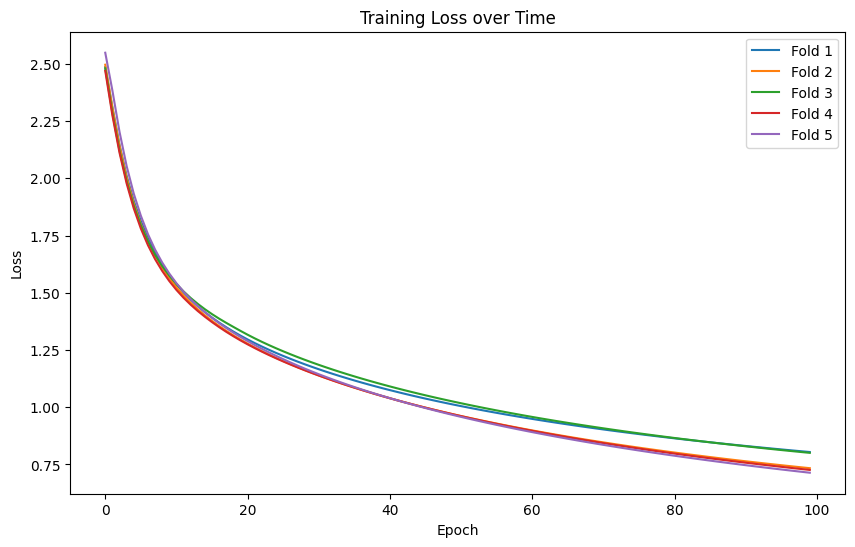

In [14]:
plot_losses(losses)

C:\Users\rgbmr\AppData\Local\Temp\ipykernel_21288\848338305.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + intents, rotation=90)
C:\Users\rgbmr\AppData\Local\Temp\ipykernel_21288\848338305.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + intents)


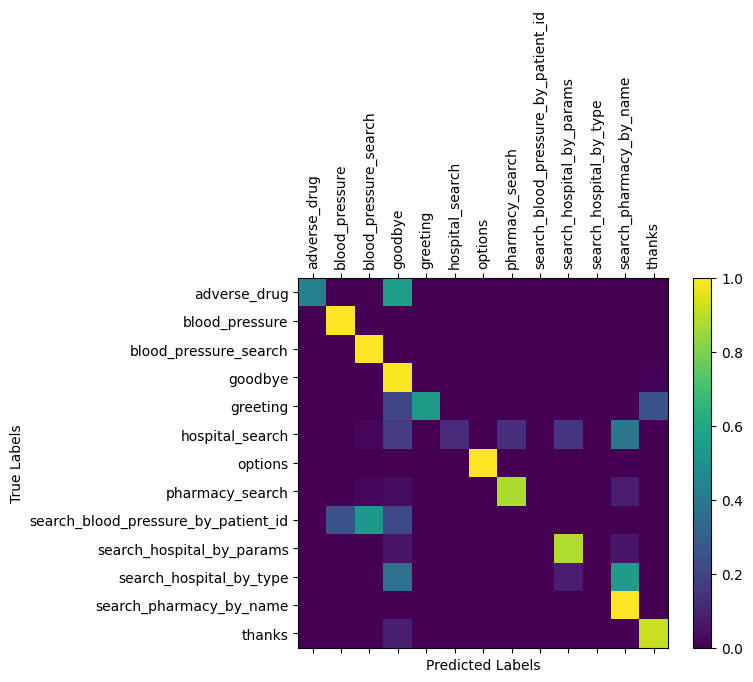

In [15]:
make_confusion(model, intents, features, labels, n_categories)

In [16]:
len(train_accuracies), len(test_accuracies)

(5, 5)

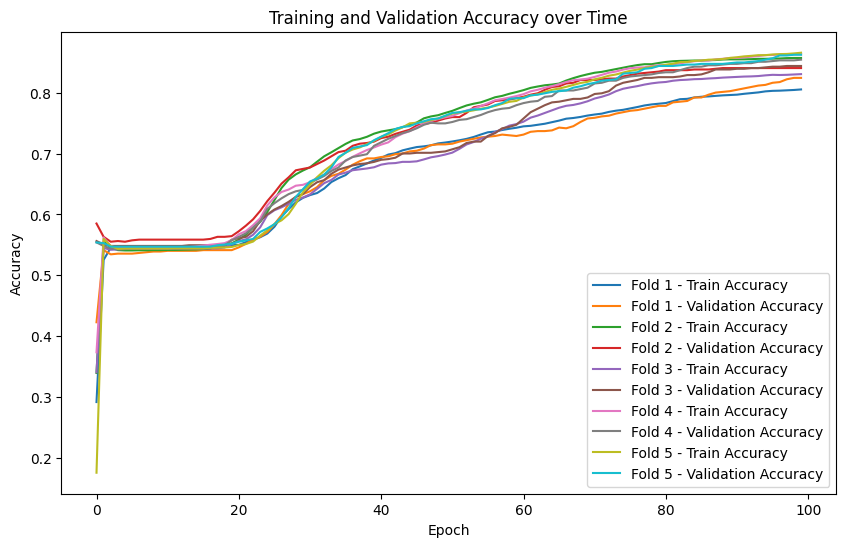

In [17]:
def plot_accuracies(fold_train_accuracies, fold_val_accuracies):
    plt.figure(figsize=(10, 6))  # Set the plot size
    for fold_idx in range(len(fold_train_accuracies)):
        plt.plot(
            fold_train_accuracies[fold_idx],
            label=f'Fold {fold_idx + 1} - Train Accuracy'
        )
        plt.plot(
            fold_val_accuracies[fold_idx],
            label=f'Fold {fold_idx + 1} - Validation Accuracy'
        )

    # Add titles and labels
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy over Time")
    plt.legend()  # Add a legend to distinguish train/validation accuracies
    plt.show()  # Display the plot

plot_accuracies(train_accuracies, test_accuracies)


Massive class imbalance toward class 2 (blood_pressure_search) and 3 (goodbye)

In [18]:
from collections import Counter
import numpy as np

def show_distribution(features, labels):
    # Example: Convert one-hot encoded vectors to class indices
    all_fold_distributions = []

    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, test_idx in kf.split(features):
        # Convert one-hot encoded labels to class indices
        class_indices = np.argmax(labels[train_idx], axis=1)  # Convert to class indices

        # Calculate class distribution in the training set
        fold_train_classes = Counter(class_indices)  # Counter expects hashable types
        all_fold_distributions.append(fold_train_classes)

    # Display class distributions for each fold
    for fold_idx, distribution in enumerate(all_fold_distributions):
        print(f"Class distribution in fold {fold_idx + 1} (train):", distribution)

In [19]:
show_distribution(features, labels)

Class distribution in fold 1 (train): Counter({2: 1013, 3: 905, 1: 299, 8: 247, 12: 205, 11: 205, 9: 143, 7: 124, 6: 96, 0: 77, 4: 72, 5: 66, 10: 48})
Class distribution in fold 2 (train): Counter({2: 1008, 3: 896, 1: 324, 8: 219, 12: 206, 11: 199, 9: 163, 7: 120, 6: 107, 0: 79, 4: 71, 5: 60, 10: 48})
Class distribution in fold 3 (train): Counter({2: 1008, 3: 900, 1: 319, 8: 237, 11: 201, 12: 195, 9: 154, 7: 118, 6: 100, 0: 75, 4: 71, 5: 69, 10: 53})
Class distribution in fold 4 (train): Counter({2: 991, 3: 926, 1: 312, 8: 220, 12: 199, 11: 199, 9: 162, 7: 116, 6: 109, 0: 87, 4: 67, 5: 64, 10: 48})
Class distribution in fold 5 (train): Counter({2: 1020, 3: 893, 1: 310, 8: 229, 12: 207, 11: 196, 9: 162, 7: 122, 6: 100, 0: 82, 4: 71, 5: 65, 10: 43})


In [20]:
intents

['adverse_drug',
 'blood_pressure',
 'blood_pressure_search',
 'goodbye',
 'greeting',
 'hospital_search',
 'options',
 'pharmacy_search',
 'search_blood_pressure_by_patient_id',
 'search_hospital_by_params',
 'search_hospital_by_type',
 'search_pharmacy_by_name',
 'thanks']

Evening out distribution by oversampling
<a id='sampling'></a>

In [21]:
from imblearn.over_sampling import RandomOverSampler

# Oversample minority classes or undersample majority classes
def over_under_sample(features, labels, sampler):
    features_oversampled, labels_indices = sampler.fit_resample(features, np.argmax(labels, axis=1))

    # Convert the class indices back to one-hot encoding
    num_classes = labels.shape[1]  # Determine the number of classes
    labels_oversampled = np.eye(num_classes)[labels_indices]  # Convert class indices back to one-hot encoding

    show_distribution(features_oversampled, labels_oversampled)

    return features_oversampled, labels_oversampled

In [22]:
ros = RandomOverSampler(random_state=1)
features_oversampled, labels_oversampled = over_under_sample(features, labels, ros)

Class distribution in fold 1 (train): Counter({12: 1031, 4: 1019, 6: 1019, 10: 1016, 5: 1015, 0: 1013, 1: 1013, 11: 1012, 2: 1008, 3: 997, 9: 988, 8: 987, 7: 986})
Class distribution in fold 2 (train): Counter({7: 1033, 4: 1026, 6: 1017, 0: 1015, 2: 1013, 10: 1013, 3: 1006, 8: 1005, 12: 1004, 5: 1001, 1: 993, 11: 993, 9: 985})
Class distribution in fold 3 (train): Counter({5: 1039, 8: 1028, 12: 1027, 1: 1026, 9: 1019, 3: 1010, 11: 1009, 4: 1005, 7: 1003, 2: 993, 6: 985, 0: 984, 10: 976})
Class distribution in fold 4 (train): Counter({3: 1028, 2: 1025, 11: 1019, 7: 1018, 0: 1017, 9: 1015, 6: 1014, 10: 1003, 4: 999, 8: 999, 1: 993, 12: 988, 5: 986})
Class distribution in fold 5 (train): Counter({9: 1033, 10: 1032, 8: 1021, 1: 1015, 0: 1011, 11: 1007, 6: 1005, 2: 1001, 7: 1000, 3: 999, 5: 999, 4: 991, 12: 990})


Oversampling provides a marked improvement to model test accuracy

In [23]:
model, accuracy, losses, train_accuracies, test_accuracies = train_and_validate(features_oversampled, labels_oversampled, 128, learning_rate, 10, 100, RNN, 5)

Epoch 1/100, Loss: 2.5136, Train Accuracy: 25.10%, Validation Accuracy: 45.81%
Epoch 11/100, Loss: 1.5373, Train Accuracy: 78.08%, Validation Accuracy: 75.72%
Epoch 21/100, Loss: 1.1322, Train Accuracy: 82.17%, Validation Accuracy: 79.05%
Epoch 31/100, Loss: 0.9311, Train Accuracy: 83.11%, Validation Accuracy: 79.66%
Epoch 41/100, Loss: 0.8122, Train Accuracy: 83.63%, Validation Accuracy: 80.40%
Epoch 51/100, Loss: 0.7333, Train Accuracy: 83.85%, Validation Accuracy: 80.83%
Epoch 61/100, Loss: 0.6766, Train Accuracy: 84.40%, Validation Accuracy: 81.35%
Epoch 71/100, Loss: 0.6340, Train Accuracy: 84.74%, Validation Accuracy: 81.62%
Epoch 81/100, Loss: 0.6003, Train Accuracy: 84.82%, Validation Accuracy: 81.68%
Epoch 91/100, Loss: 0.5724, Train Accuracy: 84.94%, Validation Accuracy: 81.80%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 7.55%
Epoch 1/100, Loss: 2.5210, Train Accuracy: 25.21%, Validation Accuracy: 42.60%
Epoch 11/100, Loss: 1.5113, Train Accuracy: 82.50%, Validation Accuracy: 83.27%
Epoch 21/100, Loss: 1.0375, Train Accuracy: 88.13%, Validation Accuracy: 88.69%
Epoch 31/100, Loss: 0.7963, Train Accuracy: 89.59%, Validation Accuracy: 90.31%
Epoch 41/100, Loss: 0.6540, Train Accuracy: 90.71%, Validation Accuracy: 91.22%
Epoch 51/100, Loss: 0.5610, Train Accuracy: 91.08%, Validation Accuracy: 91.56%
Epoch 61/100, Loss: 0.4955, Train Accuracy: 91.17%, Validation Accuracy: 91.62%
Epoch 71/100, Loss: 0.4469, Train Accuracy: 91.24%, Validation Accuracy: 91.65%
Epoch 81/100, Loss: 0.4088, Train Accuracy: 91.72%, Validation Accuracy: 92.20%
Epoch 91/100, Loss: 0.3787, Train Accuracy: 91.71%, Validation Accuracy: 92.20%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 7.49%
Epoch 1/100, Loss: 2.5124, Train Accuracy: 27.42%, Validation Accuracy: 52.75%
Epoch 11/100, Loss: 1.5716, Train Accuracy: 77.93%, Validation Accuracy: 77.28%
Epoch 21/100, Loss: 1.0851, Train Accuracy: 87.80%, Validation Accuracy: 87.86%
Epoch 31/100, Loss: 0.8149, Train Accuracy: 89.88%, Validation Accuracy: 90.15%
Epoch 41/100, Loss: 0.6622, Train Accuracy: 90.62%, Validation Accuracy: 90.98%
Epoch 51/100, Loss: 0.5652, Train Accuracy: 90.95%, Validation Accuracy: 91.31%
Epoch 61/100, Loss: 0.4980, Train Accuracy: 91.26%, Validation Accuracy: 91.59%
Epoch 71/100, Loss: 0.4483, Train Accuracy: 91.65%, Validation Accuracy: 92.02%
Epoch 81/100, Loss: 0.4101, Train Accuracy: 91.76%, Validation Accuracy: 92.17%
Epoch 91/100, Loss: 0.3794, Train Accuracy: 92.12%, Validation Accuracy: 92.63%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 8.44%
Epoch 1/100, Loss: 2.5062, Train Accuracy: 27.89%, Validation Accuracy: 47.00%
Epoch 11/100, Loss: 1.5662, Train Accuracy: 80.14%, Validation Accuracy: 80.55%
Epoch 21/100, Loss: 1.1627, Train Accuracy: 84.11%, Validation Accuracy: 84.68%
Epoch 31/100, Loss: 0.9558, Train Accuracy: 85.60%, Validation Accuracy: 85.81%
Epoch 41/100, Loss: 0.8308, Train Accuracy: 85.71%, Validation Accuracy: 86.09%
Epoch 51/100, Loss: 0.7473, Train Accuracy: 85.84%, Validation Accuracy: 86.15%
Epoch 61/100, Loss: 0.6868, Train Accuracy: 86.27%, Validation Accuracy: 86.36%
Epoch 71/100, Loss: 0.6409, Train Accuracy: 86.32%, Validation Accuracy: 86.45%
Epoch 81/100, Loss: 0.6051, Train Accuracy: 86.61%, Validation Accuracy: 86.79%
Epoch 91/100, Loss: 0.5759, Train Accuracy: 86.74%, Validation Accuracy: 86.97%


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy for this fold: 7.43%
Epoch 1/100, Loss: 2.5237, Train Accuracy: 19.91%, Validation Accuracy: 29.85%
Epoch 11/100, Loss: 1.5306, Train Accuracy: 83.89%, Validation Accuracy: 84.04%
Epoch 21/100, Loss: 1.0409, Train Accuracy: 88.66%, Validation Accuracy: 88.53%
Epoch 31/100, Loss: 0.7951, Train Accuracy: 89.98%, Validation Accuracy: 90.06%
Epoch 41/100, Loss: 0.6520, Train Accuracy: 90.79%, Validation Accuracy: 91.25%
Epoch 51/100, Loss: 0.5590, Train Accuracy: 91.04%, Validation Accuracy: 91.47%
Epoch 61/100, Loss: 0.4938, Train Accuracy: 91.18%, Validation Accuracy: 91.53%
Epoch 71/100, Loss: 0.4454, Train Accuracy: 91.23%, Validation Accuracy: 91.68%
Epoch 81/100, Loss: 0.4078, Train Accuracy: 91.42%, Validation Accuracy: 91.96%
Epoch 91/100, Loss: 0.3779, Train Accuracy: 92.26%, Validation Accuracy: 92.72%
Final Test Accuracy for this fold: 7.61%
Average Test Accuracy across all folds: 7.706422018348624
Average Test Precision across all folds: 0.595273499237812
Av

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


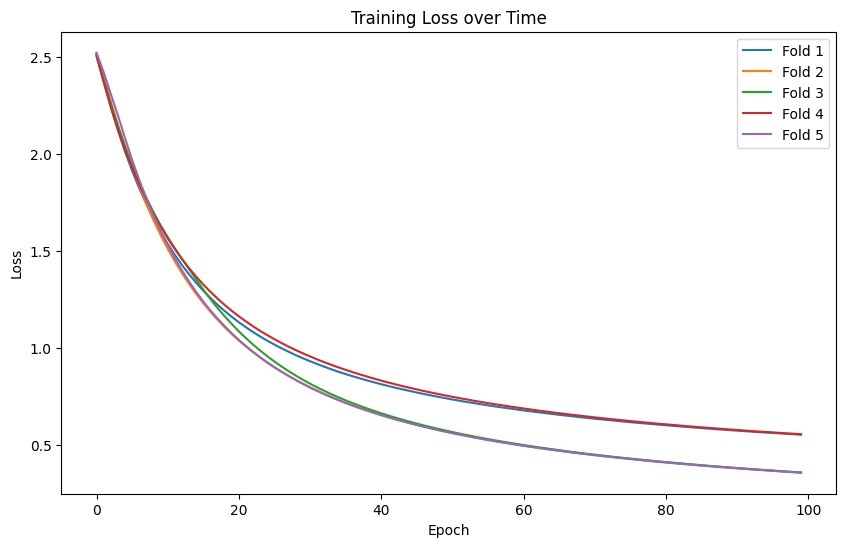

In [24]:
plot_losses(losses)

C:\Users\rgbmr\AppData\Local\Temp\ipykernel_21288\848338305.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + intents, rotation=90)
C:\Users\rgbmr\AppData\Local\Temp\ipykernel_21288\848338305.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + intents)


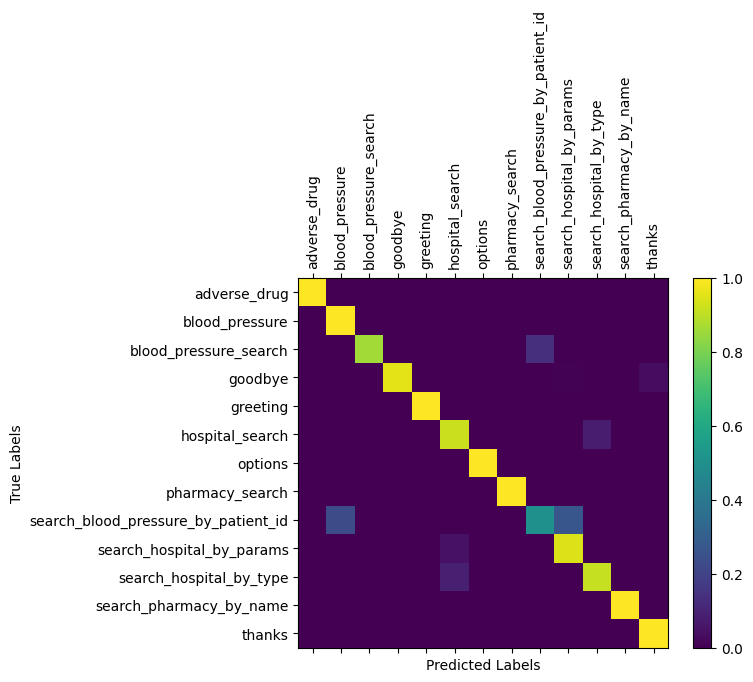

In [25]:
make_confusion(model, intents, features_oversampled, labels_oversampled, n_categories)

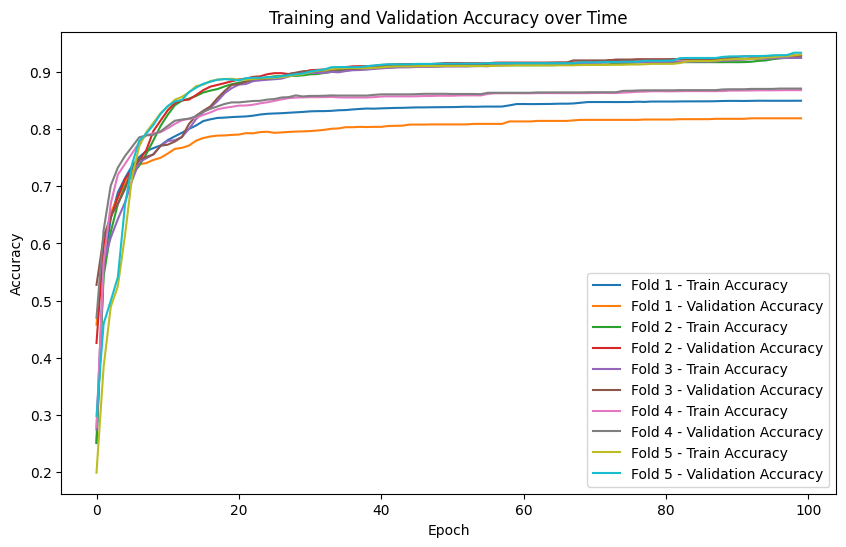

In [26]:
plot_accuracies(train_accuracies, test_accuracies)

In [27]:
def predict(model, input_line, words, n_predictions=3):
    # Just return an output given a line
    def evaluate(line_tensor):
        hidden = model.initHidden(line_tensor.size(0))
        output, hidden = model(line_tensor, hidden)

        return output
    
    def words_in_bag(sentence):
        lemmatizer = WordNetLemmatizer()
        if sentence is None:
            return np.zeros(len(words))
        sentence_words = nltk.tokenize.word_tokenize(sentence)
        sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
        bag = [0] * len(words)
        for s in sentence_words:
            for i, w in enumerate(words):
                if w == s:
                    bag[i] = 1
        return np.array(bag)
    
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(torch.from_numpy(words_in_bag(input_line)).view(1, -1))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, intents[category_index]))
            predictions.append([value, intents[category_index]])

In [28]:
predict(model, 'where is a hospital', words)


> where is a hospital
(-1.03) hospital_search
(-1.34) search_hospital_by_type
(-1.56) search_hospital_by_params


In [29]:
# Save the model
torch.save(model, '../clean_data/models/intents_classifier.pth')